Please enter number of future time periods to predict :440
Enter the frequency of your data. Example 1T for one munute, 10T for ten minutes 1D for daily ETC.:10T
                        1
0                        
2021-03-27 05:50:00  14.0
2021-03-27 06:00:00  14.0
2021-03-27 06:10:00  12.0
2021-03-27 06:20:00  22.0
2021-03-27 06:30:00  29.0
505
Epoch 1/10
132/132 [==============================] - 3s 12ms/step - loss: 0.5101 - val_loss: 0.5512
Epoch 2/10
132/132 [==============================] - 1s 9ms/step - loss: 0.2427 - val_loss: 0.2655
Epoch 3/10
132/132 [==============================] - 1s 9ms/step - loss: 0.1671 - val_loss: 0.1973
Epoch 4/10
132/132 [==============================] - 1s 9ms/step - loss: 0.1351 - val_loss: 0.2239
Epoch 5/10
132/132 [==============================] - 1s 9ms/step - loss: 0.1217 - val_loss: 0.1700
Epoch 6/10
132/132 [==============================] - 1s 10ms/step - loss: 0.1241 - val_loss: 0.1508
Epoch 7/10
132/132 [==============================

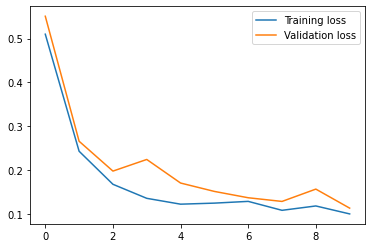

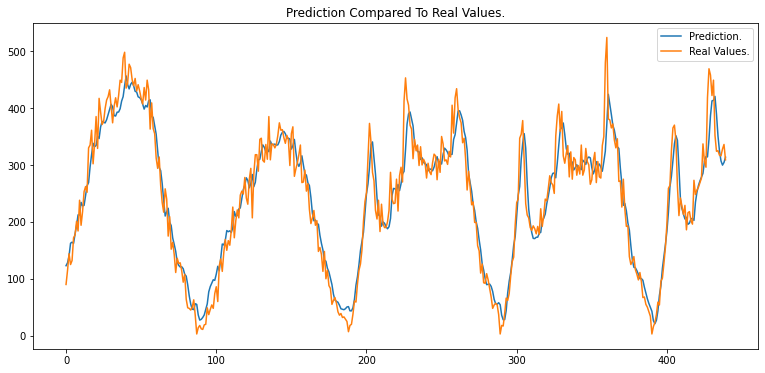

            FutureDates  Prediction
0   2021-03-31 22:30:00  122.948341
1   2021-03-31 22:40:00  128.083008
2   2021-03-31 22:50:00  140.364777
3   2021-03-31 23:00:00  162.426605
4   2021-03-31 23:10:00  164.345367
..                  ...         ...
435 2021-04-03 23:00:00  324.396454
436 2021-04-03 23:10:00  307.038757
437 2021-04-03 23:20:00  299.692078
438 2021-04-03 23:30:00  304.327972
439 2021-04-03 23:40:00  313.518280

[440 rows x 2 columns]


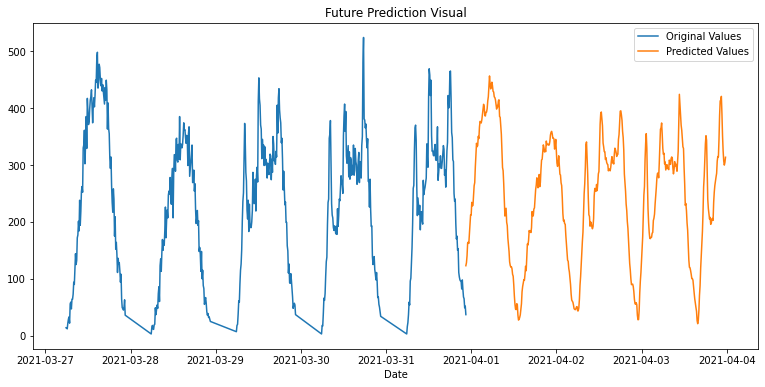

In [8]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


future_days = input("Please enter number of future time periods to predict :")
future_days = int(future_days)
time_freq = input("Enter the frequency of your data. Example 1T for one munute, 10T for ten minutes 1D for daily ETC.:")

#Data import.
#data = pd.read_csv("short.csv",index_col='date', parse_dates=True)
data = pd.read_csv("long_ascending.csv", index_col=0, parse_dates=True, header=None)
data = data.astype('float')
print(data.head())
datelist_train = list(data.index)
print(len(data))
#Scale data to a range of -1,1 and split to training and testing set.
scaler = StandardScaler()
scaler = scaler.fit(data)
dataset = scaler.transform(data)
train_data = int(len(dataset) * 0.9)
test_data = (int(len(dataset) - train_data ))
train, test = dataset[0:train_data], dataset[train_data:len(dataset)]
# Reshape data to lenght, timesteps and number of features.
n_future = 1 
n_past = 14 
def create_dataset(my_data, n_future, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(my_data) - n_future +1):
        dataX.append(my_data[i - n_past:i, 0:my_data.shape[1]])
        dataY.append(my_data[i + n_future - 1:i + n_future, 0])
    return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(train, n_future, n_past)
testX, testY = create_dataset(test, n_future, n_past)
#RNN model  starts.
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=10,validation_split=0.1, batch_size=3)
model.summary()
# Plot model loss comparison.
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
#Chart to compare real vs predicted values in the model training.
plt.figure(figsize=(13,6))
test_prediction0 = model.predict(trainX)
test_prediction1 = np.repeat(test_prediction0, data.shape[1], axis=-1)
real0 = np.repeat(trainY, data.shape[1], axis=-1)
test_prediction = scaler.inverse_transform(test_prediction1)
real = scaler.inverse_transform(real0)
plt.title("Prediction Compared To Real Values.")
plt.plot(test_prediction, label = "Prediction.")
plt.plot(real, label = "Real Values.")
plt.legend()
plt.savefig('Traincompare.png')
plt.show()
# Create future date list.
future_prediction_real = future_days
datelist_future = pd.date_range(datelist_train[-1], periods=future_prediction_real, freq=time_freq).tolist()
# Predict future days.
prediction = model.predict(trainX[-future_prediction_real:])
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
# Create date list table and future pediction table and combine side by side.
datelist_future_ = []
for i in datelist_future:
    datelist_future_.append(i.date())

data_forecust = pd.DataFrame({'FutureDates':np.array(datelist_future), 'Prediction':y_pred_future})
data_forecust['FutureDates']=pd.to_datetime(data_forecust['FutureDates'])

print(pd.DataFrame(data_forecust))
#Figure to visualise the models future prediction.
plt.figure(figsize=(13,6))
plt.title("Future Prediction Visual")
plt.xlabel("Date")
plt.plot(data, label="Original Values")
plt.plot(datelist_future,y_pred_future, label = "Predicted Values")
plt.legend()
plt.savefig('futurefig.png')
plt.show()

